In [2]:
!pip3 -q install openpyxl
!pip3 -q install wget

In [18]:
import pandas as pd
import geopandas as gpd
import rasterio as rio 
import os, wget, enum
import numpy as np
import datetime as dt
from joblib import dump, load
# import seaborn as sns
import matplotlib.pyplot as plt


import os
import pandas as pd
import numpy as np
import rasterio as rio
from itertools import product
from rasterio import windows
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo.gdalconst import GDT_Int16

In [19]:
def NDVI(red: pd.Series, nir: pd.Series):
    ndvi = (nir - red) / ((nir + red).apply(lambda x: 0.000001 if x == 0 else x))
    return ndvi

def EVI(red: pd.Series, nir: pd.Series):
    evi2 = (
        2.5
        * (nir - red)
        / ((nir + 2.4 * red + 1).apply(lambda x: 0.000001 if x == 0 else x))
    )
    return evi2

def NDRE(red_far: pd.Series, nir: pd.Series):
    ndre = (nir - red_far) / (
        (nir + red_far).apply(lambda x: 0.000001 if x == 0 else x)
    )
    return ndre

def MSAVI(red: pd.Series, nir: pd.Series):
    msavi = (2 * nir + 1 - ((2 * nir + 1) ** 2 - 8 * (nir - red)) ** (1 / 2)) / 2
    return msavi


def FCI(red: pd.Series, nir: pd.Series):
    fci = np.sqrt(red * nir)
    return fci

def normalize_pixel(X: np.ndarray) -> np.ndarray:
    X = X / 10000
    X = np.clip(X, 0, 0.3)
    return X

        
def get_SVI(df: pd.DataFrame) -> pd.DataFrame:
    nir = df.loc[:, "B8"]
    red = df.loc[:, "B4"]
    red_far = df.loc[:, "B5"]
    df.loc[:, "NDVI"] = NDVI(red=red, nir=nir)
    df.loc[:, "NDRE"] = NDRE(red_far=red_far, nir=nir)
    df.loc[:, "MSAVI"] = MSAVI(red=red, nir=nir)
    df.loc[:, "EVI"] = EVI(red=red, nir=nir)
    df.loc[:, "FCI"] = FCI(red=red, nir=nir)
    return df


def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

def get_dataset(x: np.ndarray)->pd.DataFrame:
    
    bands = x[:13, ...]
    bands = to_2d_array(x[:13, ...])    
    df = pd.DataFrame(bands.T, columns=col_names)
#     df[col_names] = normalize_pixel(df.values)
    df = get_SVI(df)
    return df

def to_2d_array(x: np.ndarray)->np.ndarray:
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def save_tif(raster_input:str, raster_output:str, values:np.array):
    in_data, out_data = None, None
    in_data = gdal.Open(raster_input)
    if in_data is None:
        print ('Unable to open %s' % raster_input)
    band1 = in_data.GetRasterBand(1)
    rows = in_data.RasterYSize
    cols = in_data.RasterXSize
    driver = in_data.GetDriver()
    out_data = driver.Create(raster_output, cols, rows, 1, GDT_Int16)
    dem_data = np.array(values)
    out_band = out_data.GetRasterBand(1)
    out_band.WriteArray(dem_data)
    out_band.FlushCache()
    out_band.SetNoDataValue(-1)

    out_data.SetGeoTransform(in_data.GetGeoTransform())
    out_data.SetProjection(in_data.GetProjection())
    del out_data
    return 'Done'

In [5]:
fname='../shape_data/Kolva/пробы_сводная_с_метриками_сколтех.xlsx'
df = pd.read_excel(fname,sheet_name='Лист1', engine='openpyxl')

In [6]:
gdf = gpd.GeoDataFrame(data=df, crs='EPSG:32640', 
                       geometry=gpd.points_from_xy(x=df.X_UTM40, y=df.Y_UTM40))

In [7]:
plots_gdf = gdf.copy()
plots_gdf['geometry'] = plots_gdf['geometry'].buffer(9)

In [8]:
plots_gdf.to_file('../shape_data/Kolva/plots.geojson', driver='GeoJSON')

In [9]:
gdf = gpd.read_file('../shape_data/Kolva/plots.geojson')

In [10]:
non_forest = gpd.read_file('../shape_data/Kolva/non_forest.shp')

In [11]:
def get_dataset(gdf: gpd.GeoDataFrame, non_forest:gpd.GeoDataFrame, threshold: float=80):
    assert threshold<1, 'threshold in range 0 to 1'
    code_class = {'PRC_B':1, 
                  'PRC_OS':2,
                  'PRC_IVD': 3, 
                  'PRC_OLS': 4, 
                  'PRC_K':5, 
                  'PRC_S':6, 
                  'PRC_E':7,
                  'PRC_P':8}
    
    target_cols = list(code_class.keys())
    
    mask = gdf[target_cols]>threshold
    
    select=gdf.loc[mask.any(axis=1)].copy()
    
    t = select.loc[:, target_cols].idxmax(axis=1)
    
    select.loc[:, 't'] = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, 'class'] = select['t'].apply(lambda x : code_class[x])
    return select[['class', 'geometry']]

In [12]:
gdf = gpd.read_file('../shape_data/Kolva/plots.geojson')
non_forest = gpd.read_file('../shape_data/Kolva/non_forest.shp')
non_forest = non_forest.to_crs(gdf.crs)
non_forest['class'] = 9
forest = get_dataset(gdf=gdf, non_forest=non_forest,threshold=0.7)

In [13]:
dataset = pd.concat([forest, non_forest])

In [14]:
kvartals = gpd.read_file('../shape_data/Kolva/кварталы.shp')

In [17]:
kvartals.crs

<Projected CRS: EPSG:32640>
Name: WGS 84 / UTM zone 40N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 54°E and 60°E, northern hemisphere between equator and 84°N, onshore and offshore. Islamic Republic of Iran. kazakhstan. Oman. Russian Federation. Saudi Arabia. Turkmenistan. United Arab Emirates. Uzbekistan.
- bounds: (54.0, 0.0, 60.0, 84.0)
Coordinate Operation:
- name: UTM zone 40N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
kvartals.total_bounds

array([ 488307.19489799, 6734267.75736112,  584591.89379509,
       6819072.72034639])

In [20]:
fname = '../rasters/mosaic_kvartal.tif'
with rio.open(fname, 'r+') as src:
    bbox = src.bounds

In [29]:
import shapely.geometry

polygon = shapely.geometry.box(*bbox, ccw=True)

In [30]:
bounds = gpd.GeoDataFrame(data=['bbox'], geometry=[polygon], crs = gdf.crs)

In [52]:
data = gpd.sjoin(dataset, bounds)

In [55]:
data = data.reset_index(drop=True)
data = data.iloc[:, :2]
data.loc[:, 'key'] = data.index

In [69]:
data.groupby('class').count()

,geometry,key
class,,
1,117,117
2,36,36
6,16,16
7,131,131
8,17,17
9,21,21


In [67]:
mask = data['class'] != 3
data = data.loc[mask]
mask = data['class'] != 5
data = data.loc[mask]

<BarContainer object of 6 artists>

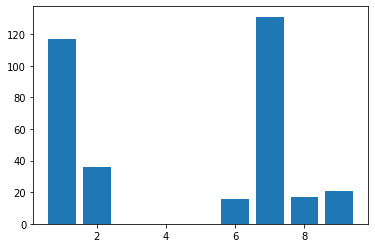

In [68]:
plt.bar(x=data.groupby('class').count().index, height=data.groupby('class').count().key)

In [87]:

import importlib
import utils_kolva
importlib.reload(utils_kolva)

<module 'utils_kolva' from '/home/notebooks/utils_kolva.py'>

In [89]:
dataset = utils_kolva.Dataset(path_to_tiff_file='../rasters/mosaic.tif')
# dataset.download_dataset()

# gdf=dataset.procces_gdf(gdf)
bands = dataset.get_dataset(gdf=data, scale=2.0)

Radius of forest plot: 17.99
Start preparing bands  -- Done ✅
Start preparing terrain


In [92]:
fci = pd.DataFrame(np.sqrt(bands['B4'] * bands['B8']), columns=['FCI'])
bands = pd.concat([bands.iloc[:, :-2],  fci, bands.iloc[:, -2:]], axis=1)

In [94]:

# Fill diagonal and upper half with NaNs
corr = bands.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.iloc[:, :]
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))


/tmp/ipykernel_11/536678407.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr.iloc[:, :]


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,EVI,MSAVI,NDRE,FCI
B1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B2,0.82,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B3,0.78,0.94,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B4,0.72,0.92,0.92,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B5,0.72,0.87,0.95,0.93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B6,0.60,0.69,0.79,0.59,0.77,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B7,0.55,0.63,0.72,0.51,0.70,0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B8,0.54,0.65,0.75,0.53,0.71,0.97,0.97,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
B8A,0.57,0.66,0.76,0.56,0.74,0.99,0.99,0.97,nan,nan,nan,nan,nan,nan,nan,nan,nan
B9,0.61,0.68,0.76,0.60,0.76,0.94,0.94,0.92,0.95,nan,nan,nan,nan,nan,nan,nan,nan


## Классификация лес - не лес

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


from sklearn import model_selection

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import loguniform
# from imblearn.over_sampling import SMOTE 
# from imblearn.combine import SMOTEENN, SMOTETomek
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from scipy.stats import loguniform

In [173]:
df = bands.copy()
df.iloc[:, :-3] = StandardScaler().fit_transform(df.iloc[:, :-3])

### Модель леса

In [174]:
class ForestClasses(enum.Enum):
    PRC_B = 1
    PRC_OS = 2
    PRC_IVD = 3
    PRC_OLS = 4
    PRC_K = 5 
    PRC_S = 6 
    PRC_E = 7
    PRC_P = 8
    NON_FOREST = 9

In [175]:
def code_forest_class(df: pd.DataFrame)->pd.DataFrame:
    mask_forest = df['class']!=ForestClasses.NON_FOREST.value
    df['forest'] = -999
    df.loc[mask_forest, 'forest'] = 1
    df.loc[mask_non_forest, 'forest'] = 0
    return df


def code_forest_type_class(df: pd.DataFrame)->pd.DataFrame:
    
    forest_type = {"Deciduous":0, "Coniferous":1}
    mask_coniferous = df['class'].isin([1,2,3,4])
    mask_deciduous = df['class'].isin([5,6,7,8])
    df['forest_type'] = -999
    df.loc[mask_coniferous, 'forest_type'] = forest_type['Coniferous']
    df.loc[mask_deciduous, 'forest_type'] = forest_type['Deciduous']
    return df

In [224]:
df = bands.copy()
df.iloc[:, :-2] = StandardScaler().fit_transform(df.iloc[:, :-2].values)
df = code_forest_class(df)
# df = code_forest_type_class(df)

In [226]:
forest_gdf = data
X_train, X_test, y_train, y_test = train_test_split(forest_gdf,
                                                    forest_gdf['class'],
                                                    test_size=0.25)

assert set(y_test) == set(y_train), 'Houston, we have problems'
train = df.loc[df['key'].isin(X_train['key'])]
test = df.loc[df['key'].isin(X_test['key'])]
remove_cols = ['key','class','forest']
X_train = train.drop(columns=remove_cols).astype('float')
X_test = test.drop(columns=remove_cols).astype('float')
y_train = train['forest'].astype(int)
y_test = test['forest'].astype(int)

In [228]:
param_grid = {
    "n_estimators": range(5, 100, 10),
    "max_leaf_nodes": range(2, 100, 10),
    "min_samples_split": range(2, 50, 5),
    "learning_rate": loguniform.rvs(0.01, 1, size=10),
}

gs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    n_iter=50,
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    refit="f1",
    n_jobs=1,
    return_train_score=True,
    verbose=10
)
gs.fit(X_train, y_train)
results = gs.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55
[CV 1/5; 1/50] END learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55;, score=(train=1.000, test=0.979) total time=   1.1s
[CV 2/5; 1/50] START learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55
[CV 2/5; 1/50] END learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55;, score=(train=1.000, test=0.957) total time=   1.1s
[CV 3/5; 1/50] START learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55
[CV 3/5; 1/50] END learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55;, score=(train=1.000, test=0.982) total time=   1.1s
[CV 4/5; 1/50] START learning_rate=0.9058150248557739, max_leaf_nodes=12, min_samples_split=7, n_estimators=55
[CV 4/5;

[CV 1/5; 7/50] END learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25;, score=(train=1.000, test=0.990) total time=   0.5s
[CV 2/5; 7/50] START learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25
[CV 2/5; 7/50] END learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25;, score=(train=1.000, test=0.984) total time=   0.5s
[CV 3/5; 7/50] START learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25
[CV 3/5; 7/50] END learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25;, score=(train=1.000, test=0.973) total time=   0.5s
[CV 4/5; 7/50] START learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25
[CV 4/5; 7/50] END learning_rate=0.4785782426654715, max_leaf_nodes=12, min_samples_split=27, n_estimators=25;, score=(train=1.000, test=0.999) total time=   0.5s
[CV 5/5; 7/5

[CV 2/5; 13/50] END learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5;, score=(train=0.995, test=0.990) total time=   0.1s
[CV 3/5; 13/50] START learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5
[CV 3/5; 13/50] END learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5;, score=(train=0.998, test=0.973) total time=   0.1s
[CV 4/5; 13/50] START learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5
[CV 4/5; 13/50] END learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5;, score=(train=0.995, test=0.998) total time=   0.1s
[CV 5/5; 13/50] START learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5
[CV 5/5; 13/50] END learning_rate=0.14048177035575232, max_leaf_nodes=52, min_samples_split=32, n_estimators=5;, score=(train=0.992, test=0.993) total time=   0.1s
[CV 1

[CV 2/5; 19/50] END learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75;, score=(train=1.000, test=0.990) total time=   1.4s
[CV 3/5; 19/50] START learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75
[CV 3/5; 19/50] END learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75;, score=(train=1.000, test=0.974) total time=   1.4s
[CV 4/5; 19/50] START learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75
[CV 4/5; 19/50] END learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75;, score=(train=1.000, test=0.999) total time=   1.4s
[CV 5/5; 19/50] START learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75
[CV 5/5; 19/50] END learning_rate=0.08964047403507965, max_leaf_nodes=42, min_samples_split=7, n_estimators=75;, score=(train=1.000, test=0.993) total time=   1.4s
[CV 1

[CV 2/5; 25/50] END learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85;, score=(train=0.994, test=0.999) total time=   1.1s
[CV 3/5; 25/50] START learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85
[CV 3/5; 25/50] END learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85;, score=(train=0.998, test=0.973) total time=   1.1s
[CV 4/5; 25/50] START learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85
[CV 4/5; 25/50] END learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85;, score=(train=0.995, test=0.998) total time=   1.1s
[CV 5/5; 25/50] START learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85
[CV 5/5; 25/50] END learning_rate=0.06225455442505566, max_leaf_nodes=2, min_samples_split=17, n_estimators=85;, score=(train=0.995, test=0.996) total time=   1.1s
[CV 1

[CV 2/5; 31/50] END learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85;, score=(train=1.000, test=0.990) total time=   1.6s
[CV 3/5; 31/50] START learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85
[CV 3/5; 31/50] END learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85;, score=(train=1.000, test=0.976) total time=   1.6s
[CV 4/5; 31/50] START learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85
[CV 4/5; 31/50] END learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85;, score=(train=0.999, test=0.999) total time=   1.7s
[CV 5/5; 31/50] START learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85
[CV 5/5; 31/50] END learning_rate=0.06225455442505566, max_leaf_nodes=32, min_samples_split=27, n_estimators=85;, score=(train=0.999, test=0.993) total time=   1.7

[CV 2/5; 37/50] END learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85;, score=(train=1.000, test=0.989) total time=   1.7s
[CV 3/5; 37/50] START learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85
[CV 3/5; 37/50] END learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85;, score=(train=1.000, test=0.976) total time=   1.7s
[CV 4/5; 37/50] START learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85
[CV 4/5; 37/50] END learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85;, score=(train=1.000, test=0.999) total time=   1.6s
[CV 5/5; 37/50] START learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85
[CV 5/5; 37/50] END learning_rate=0.144140546419481, max_leaf_nodes=62, min_samples_split=22, n_estimators=85;, score=(train=1.000, test=0.993) total time=   1.7s
[CV 1/5; 38/

[CV 2/5; 43/50] END learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75;, score=(train=0.995, test=0.990) total time=   1.5s
[CV 3/5; 43/50] START learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75
[CV 3/5; 43/50] END learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75;, score=(train=0.999, test=0.973) total time=   1.4s
[CV 4/5; 43/50] START learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75
[CV 4/5; 43/50] END learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75;, score=(train=0.996, test=0.999) total time=   1.5s
[CV 5/5; 43/50] START learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75
[CV 5/5; 43/50] END learning_rate=0.024181148590232186, max_leaf_nodes=72, min_samples_split=27, n_estimators=75;, score=(train=0.996, test=0.993) total time

[CV 2/5; 49/50] END learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45;, score=(train=0.994, test=0.997) total time=   0.9s
[CV 3/5; 49/50] START learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45
[CV 3/5; 49/50] END learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45;, score=(train=0.998, test=0.973) total time=   0.9s
[CV 4/5; 49/50] START learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45
[CV 4/5; 49/50] END learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45;, score=(train=0.995, test=0.998) total time=   0.9s
[CV 5/5; 49/50] START learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45
[CV 5/5; 49/50] END learning_rate=0.016167363221845147, max_leaf_nodes=42, min_samples_split=22, n_estimators=45;, score=(train=0.991, test=0.993) total time

In [229]:
forest_model = gs.best_estimator_

In [233]:
score_res = results['mean_test_score'].mean().round(2)
print('f1', score_res)

f1 0.98


In [239]:
forest_gdf = data.loc[data['class']!=ForestClasses.NON_FOREST.value]
X_train, X_test, y_train, y_test = train_test_split(forest_gdf,
                                                    forest_gdf['class'],
                                                    test_size=0.25)

assert set(y_test) == set(y_train), 'Houston, we have problems'
train = df.loc[df['key'].isin(X_train['key'])]
test = df.loc[df['key'].isin(X_test['key'])]
remove_cols = ['key','class','forest']
X_train = train.drop(columns=remove_cols).astype('float')
X_test = test.drop(columns=remove_cols).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

class_weights_vals = compute_class_weight(class_weight = "balanced", 
                                          classes= np.unique(y_train),
                                          y= y_train)
class_weights = {x:y for x,y in zip(np.unique(y_train), 
                                    class_weights_vals)}

In [243]:
param_grid = {
    "n_estimators": range(5, 100, 10),
    "max_leaf_nodes": range(2, 100, 10),
    "min_samples_split": range(2, 50, 5),
    "learning_rate": loguniform.rvs(0.01, 1, size=10),
}

gs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    n_iter=50,
    param_distributions=param_grid,
    scoring='f1_macro',
    cv=5,
    refit="f1_macro",
    n_jobs=1,
    return_train_score=True,
    verbose=10
)
gs.fit(X_train, y_train)
results = gs.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimators=95
[CV 1/5; 1/50] END learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimators=95;, score=(train=0.732, test=0.675) total time=   8.3s
[CV 2/5; 1/50] START learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimators=95
[CV 2/5; 1/50] END learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimators=95;, score=(train=0.718, test=0.630) total time=   8.7s
[CV 3/5; 1/50] START learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimators=95
[CV 3/5; 1/50] END learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimators=95;, score=(train=0.761, test=0.657) total time=   8.8s
[CV 4/5; 1/50] START learning_rate=0.01720310025363584, max_leaf_nodes=52, min_samples_split=27, n_estimato

[CV 1/5; 7/50] END learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25;, score=(train=0.995, test=0.659) total time=   2.2s
[CV 2/5; 7/50] START learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25
[CV 2/5; 7/50] END learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25;, score=(train=1.000, test=0.646) total time=   2.3s
[CV 3/5; 7/50] START learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25
[CV 3/5; 7/50] END learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25;, score=(train=1.000, test=0.720) total time=   2.4s
[CV 4/5; 7/50] START learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25
[CV 4/5; 7/50] END learning_rate=0.7729994393954883, max_leaf_nodes=12, min_samples_split=22, n_estimators=25;, score=(train=0.998, test=0.634) total time=   2.2s
[CV 5/5; 7/5

[CV 1/5; 13/50] END learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35;, score=(train=0.536, test=0.441) total time=   2.1s
[CV 2/5; 13/50] START learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35
[CV 2/5; 13/50] END learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35;, score=(train=0.484, test=0.417) total time=   2.1s
[CV 3/5; 13/50] START learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35
[CV 3/5; 13/50] END learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35;, score=(train=0.526, test=0.528) total time=   2.1s
[CV 4/5; 13/50] START learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35
[CV 4/5; 13/50] END learning_rate=0.01720310025363584, max_leaf_nodes=2, min_samples_split=7, n_estimators=35;, score=(train=0.541, test=0.499) total time=   2.1s
[CV 5/5; 13/

[CV 1/5; 19/50] END learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35;, score=(train=0.611, test=0.540) total time=   2.2s
[CV 2/5; 19/50] START learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35
[CV 2/5; 19/50] END learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35;, score=(train=0.590, test=0.547) total time=   2.1s
[CV 3/5; 19/50] START learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35
[CV 3/5; 19/50] END learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35;, score=(train=0.600, test=0.583) total time=   2.1s
[CV 4/5; 19/50] START learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35
[CV 4/5; 19/50] END learning_rate=0.03892947412738581, max_leaf_nodes=2, min_samples_split=27, n_estimators=35;, score=(train=0.605, test=0.575) total time=   2.2s
[CV 5

[CV 1/5; 25/50] END learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45;, score=(train=0.667, test=0.596) total time=   4.0s
[CV 2/5; 25/50] START learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45
[CV 2/5; 25/50] END learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45;, score=(train=0.649, test=0.594) total time=   4.0s
[CV 3/5; 25/50] START learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45
[CV 3/5; 25/50] END learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45;, score=(train=0.630, test=0.590) total time=   4.0s
[CV 4/5; 25/50] START learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45
[CV 4/5; 25/50] END learning_rate=0.010822563822486014, max_leaf_nodes=12, min_samples_split=37, n_estimators=45;, score=(train=0.654, test=0.542) total time

[CV 1/5; 31/50] END learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65;, score=(train=1.000, test=0.743) total time=   5.7s
[CV 2/5; 31/50] START learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65
[CV 2/5; 31/50] END learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65;, score=(train=1.000, test=0.724) total time=   5.8s
[CV 3/5; 31/50] START learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65
[CV 3/5; 31/50] END learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65;, score=(train=1.000, test=0.708) total time=   5.8s
[CV 4/5; 31/50] START learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65
[CV 4/5; 31/50] END learning_rate=0.270359344916672, max_leaf_nodes=32, min_samples_split=22, n_estimators=65;, score=(train=1.000, test=0.628) total time=   5.7s
[CV 5/5; 31/

[CV 1/5; 37/50] END learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85;, score=(train=0.877, test=0.667) total time=   7.5s
[CV 2/5; 37/50] START learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85
[CV 2/5; 37/50] END learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85;, score=(train=0.895, test=0.629) total time=   7.3s
[CV 3/5; 37/50] START learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85
[CV 3/5; 37/50] END learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85;, score=(train=0.872, test=0.659) total time=   7.3s
[CV 4/5; 37/50] START learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85
[CV 4/5; 37/50] END learning_rate=0.03892947412738581, max_leaf_nodes=42, min_samples_split=7, n_estimators=85;, score=(train=0.868, test=0.622) total time=   7.5s
[CV 5

[CV 1/5; 43/50] END learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55;, score=(train=0.679, test=0.599) total time=   4.8s
[CV 2/5; 43/50] START learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55
[CV 2/5; 43/50] END learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55;, score=(train=0.661, test=0.608) total time=   4.7s
[CV 3/5; 43/50] START learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55
[CV 3/5; 43/50] END learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55;, score=(train=0.641, test=0.614) total time=   4.9s
[CV 4/5; 43/50] START learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55
[CV 4/5; 43/50] END learning_rate=0.010822563822486014, max_leaf_nodes=82, min_samples_split=42, n_estimators=55;, score=(train=0.656, test=0.585) total time

[CV 1/5; 49/50] END learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75;, score=(train=0.745, test=0.664) total time=   6.6s
[CV 2/5; 49/50] START learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75
[CV 2/5; 49/50] END learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75;, score=(train=0.719, test=0.629) total time=   6.6s
[CV 3/5; 49/50] START learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75
[CV 3/5; 49/50] END learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75;, score=(train=0.718, test=0.644) total time=   6.6s
[CV 4/5; 49/50] START learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75
[CV 4/5; 49/50] END learning_rate=0.01720310025363584, max_leaf_nodes=32, min_samples_split=7, n_estimators=75;, score=(train=0.760, test=0.604) total time=   6.6s
[CV 5

In [245]:
model_forest_type = gs.best_estimator_

In [256]:
dump(forest_model, '../models/forest_model.joblib') 

['../models/forest_model.joblib']

In [254]:

dump(model_forest_type, '../models/model_forest_type.joblib') 


['../models/model_forest_type.joblib']

## Inference

In [ ]:

def forest_classifier(df: pd.DataFrame, model)->np.ndarray:
    model.predict(df)
    
    mask = df['NDVI']>0.6
    return (mask*1).values


def forest_type_classifier(df: pd.DataFrame)->np.ndarray:
    # Здесь надо добавить свой классификатор, для примера, простой классифатор по NDVI
    
    # df - датафрейм со столбцами - ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
    #        'B10', 'B11', 'B12', 'NDVI', 'NDRE', 'MSAVI', 'EVI', 'aspect', 'slope',
    #        'wetnessindex', 'sink']
    # на выход надо вернуть вектор размер df.shape[0]
    mask = df['NDVI']>0.6
    return (mask*1).values


In [23]:
col_names = [
        "B1",
        "B2",
        "B3",
        "B4",
        "B5",
        "B6",
        "B7",
        "B8",
        "B8A",
        "B9",
        "B11",
        "B12",
        ]

In [25]:
land_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDRE,MSAVI,EVI,FCI
0,658.5,637.0,727.0,681.0,1115.5,1752.5,1930.5,2071.0,2181.5,2291.5,2435.5,1530.0,0.505087,0.299859,0.671120,0.937567,1187.581997
1,658.5,668.0,763.0,746.5,1115.5,1752.5,1930.5,2048.0,2181.5,2291.5,2435.5,1530.0,0.465736,0.294768,0.635441,0.847198,1236.459462
2,658.5,675.5,778.0,743.0,1101.0,1600.0,1758.5,1912.0,1984.0,2291.5,2443.5,1625.0,0.440301,0.269167,0.611340,0.790677,1191.895969
3,658.5,680.5,748.5,726.5,1101.0,1600.0,1758.5,1856.0,1984.0,2291.5,2443.5,1625.0,0.437367,0.255326,0.608503,0.784244,1161.199380
4,670.0,685.5,764.5,739.0,1106.0,1648.5,1849.5,1866.0,2001.0,2392.5,2425.5,1597.5,0.432630,0.255720,0.603902,0.773911,1174.297237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,317.5,335.0,495.0,295.0,674.5,1658.0,1909.0,2101.5,2063.0,2076.5,1059.0,500.0,0.753808,0.514049,0.859595,1.606920,787.364274
262140,306.0,344.0,441.5,261.0,696.5,1631.5,1883.0,1833.0,2065.5,1936.5,1032.0,493.5,0.750716,0.449298,0.857577,1.597301,691.674056
262141,306.0,324.0,447.5,258.0,696.5,1631.5,1883.0,1748.0,2065.5,1936.5,1032.0,493.5,0.742772,0.430149,0.852367,1.572925,671.553423
262142,306.0,330.5,450.5,271.5,613.5,1483.0,1685.0,1722.5,1807.5,1936.5,987.5,482.5,0.727683,0.474743,0.842342,1.527304,683.855796


In [26]:
land_df.loc[mask_forest]

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDRE,MSAVI,EVI,FCI


In [29]:

# Задаем размер кусочков (тайлов), которые будем классифицировать
tile_width, tile_height = 512, 512

forest_model = load('../models/forest_model.joblib')
species_model = load('../models/model_forest_type.joblib')

with rio.open(fname, 'r+') as src:
    meta = src.meta.copy()
    output_mask = np.zeros(shape = (meta['height'], meta['width']))
    # Здесь можно добавить tqdm для отслеживания процесса
    for window, transform in get_tiles(src, 
                                       width=tile_width,
                                       height=tile_height):
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        
        x = src.read(window=window)
        
        df = get_dataset(x)
        
        forecast=pd.Series(data=np.ones(shape=(len(df), 1)[0])*-1)
        
        mask_nan = df.sum(axis=1)==0
        land_df = df.loc[~mask_nan]

        land_df.iloc[:, :] = StandardScaler().fit_transform(land_df)
        
        forest_preds = forest_model.predict(land_df.values)
        forecast.loc[~mask_nan] = forest_preds
        
        mask_forest = forecast==1
        
        forecast.loc[mask_forest]=species_model.predict(land_df.loc[mask_forest])

        forest_tile = forecast.values.reshape(meta['height'], meta['width'])
        ranges = window.toranges()
        output_mask[ranges[0][0]:ranges[0][1],ranges[1][0]:ranges[1][1]] = forest_tile
        print(window)
#         break 
raster_output = '../rasters/prediction_kolva_kvartals.tif'
status = save_tif(raster_input=fname, raster_output=raster_output, values=output_mask)
print(status)

Window(col_off=0, row_off=0, width=512, height=512)
Window(col_off=0, row_off=512, width=512, height=512)
Window(col_off=0, row_off=1024, width=512, height=512)
Window(col_off=0, row_off=1536, width=512, height=512)
Window(col_off=0, row_off=2048, width=512, height=512)
Window(col_off=0, row_off=2560, width=512, height=512)
Window(col_off=0, row_off=3072, width=512, height=512)
Window(col_off=0, row_off=3584, width=512, height=512)
Window(col_off=0, row_off=4096, width=512, height=512)
Window(col_off=0, row_off=4608, width=512, height=512)
Window(col_off=0, row_off=5120, width=512, height=512)
Window(col_off=0, row_off=5632, width=512, height=512)
Window(col_off=0, row_off=6144, width=512, height=512)
Window(col_off=0, row_off=6656, width=512, height=512)
Window(col_off=0, row_off=7168, width=512, height=512)
Window(col_off=0, row_off=7680, width=512, height=512)
Window(col_off=0, row_off=8192, width=512, height=290)
Window(col_off=512, row_off=0, width=512, height=512)
Window(col_off=

Window(col_off=4096, row_off=4096, width=512, height=512)
Window(col_off=4096, row_off=4608, width=512, height=512)
Window(col_off=4096, row_off=5120, width=512, height=512)
Window(col_off=4096, row_off=5632, width=512, height=512)
Window(col_off=4096, row_off=6144, width=512, height=512)
Window(col_off=4096, row_off=6656, width=512, height=512)
Window(col_off=4096, row_off=7168, width=512, height=512)
Window(col_off=4096, row_off=7680, width=512, height=512)
Window(col_off=4096, row_off=8192, width=512, height=290)
Window(col_off=4608, row_off=0, width=512, height=512)
Window(col_off=4608, row_off=512, width=512, height=512)
Window(col_off=4608, row_off=1024, width=512, height=512)
Window(col_off=4608, row_off=1536, width=512, height=512)
Window(col_off=4608, row_off=2048, width=512, height=512)
Window(col_off=4608, row_off=2560, width=512, height=512)
Window(col_off=4608, row_off=3072, width=512, height=512)
Window(col_off=4608, row_off=3584, width=512, height=512)
Window(col_off=460

Window(col_off=8192, row_off=7168, width=512, height=512)
Window(col_off=8192, row_off=7680, width=512, height=512)
Window(col_off=8192, row_off=8192, width=512, height=290)
Window(col_off=8704, row_off=0, width=512, height=512)
Window(col_off=8704, row_off=512, width=512, height=512)
Window(col_off=8704, row_off=1024, width=512, height=512)
Window(col_off=8704, row_off=1536, width=512, height=512)
Window(col_off=8704, row_off=2048, width=512, height=512)
Window(col_off=8704, row_off=2560, width=512, height=512)
Window(col_off=8704, row_off=3072, width=512, height=512)
Window(col_off=8704, row_off=3584, width=512, height=512)
Window(col_off=8704, row_off=4096, width=512, height=512)
Window(col_off=8704, row_off=4608, width=512, height=512)
Window(col_off=8704, row_off=5120, width=512, height=512)
Window(col_off=8704, row_off=5632, width=512, height=512)
Window(col_off=8704, row_off=6144, width=512, height=512)
Window(col_off=8704, row_off=6656, width=512, height=512)
Window(col_off=870

In [320]:
print(window)

Window(col_off=0, row_off=0, width=512, height=512)


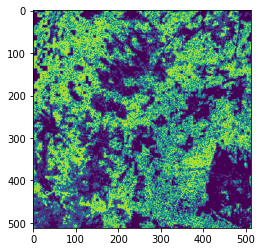

In [311]:
plt.imshow(forecast.values.reshape(meta['height'], meta['width']))

In [270]:
df.iloc[:, :] = StandardScaler().fit_transform(df)

In [285]:
mask_nan = df.sum(axis=1)==0
df.loc[mask_nan]

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDRE,MSAVI,EVI,FCI


In [322]:
with rio.open(raster_output, 'r+') as src:
    x = src.read()

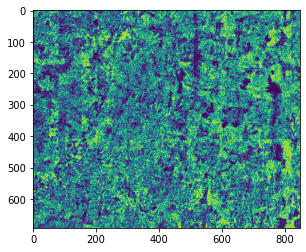

In [324]:
plt.imshow(x[0, ::10, ::10])

In [335]:
import pickle
fname = '../models/rfc_multiclass_nf.pkl'
# 

with open(fname,'rb') as file:
        model = pickle.load(file)

    
# model = pickle.load(fname)

In [342]:
model.predict(df.values)

array([17, 17, 17, ..., 17, 17, 17])

In [341]:
model.predict(df.iloc[:, :5].values)

ValueError: X has 5 features, but DecisionTreeClassifier is expecting 17 features as input.

In [11]:
import numpy as np
 
# create a numpy 1d-array
x = np.array([100,100])
 
print("Size of the array: ",
      x.size)
 
print("Memory size of one array element in bytes: ",
      x.itemsize)
 
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      x.size * x.itemsize)

Size of the array:  2
Memory size of one array element in bytes:  8
Memory size of numpy array in bytes: 16


In [17]:
import numpy as np
 
# create a numpy 1d-array
size = (100,100)
x = np.random.randint(low=1, high=8000, size=size)
 
# print("Size of the array: ",
#       x.size)
 
# print("Memory size of one array element in bytes: ",
#       x.itemsize)
 
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      x.size * x.itemsize)

Memory size of numpy array in bytes: 80000


In [18]:
size = (200,200)
x = np.random.randint(low=1, high=8000, size=size)
 
# print("Size of the array: ",
#       x.size)
 
# print("Memory size of one array element in bytes: ",
#       x.itemsize)
 
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      x.size * x.itemsize)

Memory size of numpy array in bytes: 320000


In [19]:
320000/ 80000

4.0